This file is meant to test changes to the noisy gates library downloaded in this folder offline

get API key here: ```https://cloud.ibm.com/iam/apikeys```



### Preparation

In [1]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import json
import os, sys, importlib
from typing import List
from dotenv import load_dotenv

# Qiskit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.controlflow import ControlFlowOp
from qiskit.result import marginal_counts
from qiskit.transpiler import CouplingMap, Layout
from qiskit_ibm_runtime import QiskitRuntimeService

# 0) Point to the *parent* of the package folder
LOCAL_QG_PATH = r"../src"   # or r"C:\Users\npace\Desktop\quantum-gates\src"
LOCAL_QG_PATH = os.path.abspath(LOCAL_QG_PATH)

# 1) Put local src at the very front of sys.path
if LOCAL_QG_PATH in sys.path:
    sys.path.remove(LOCAL_QG_PATH)
sys.path.insert(0, LOCAL_QG_PATH)

# 2) Purge any cached copies of the package
for m in list(sys.modules):
    if m == "quantum_gates" or m.startswith("quantum_gates."):
        del sys.modules[m]

# 3) Invalidate import caches and import the local package
importlib.invalidate_caches()
import quantum_gates

print("Using quantum_gates from:", quantum_gates.__file__)

# Own library
from quantum_gates.utilities import fix_counts
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
from quantum_gates.utilities import SurfaceCode
    


Using quantum_gates from: c:\Users\npace\Desktop\quantum-gates\src\quantum_gates\__init__.py


In [2]:
load_dotenv()  # loads .env file into environment

IBM_TOKEN = os.getenv("IBM_TOKEN")
CRN = os.getenv("CRN")

In [3]:
from qiskit_ibm_runtime.fake_provider import FakeBrisbane

def service(ibm_token: str = None):
    """
    Local version using a fake IBM Quantum backend (no cloud connection).
    """
    try:
        print("✅ Using local fake IBM Quantum backend (no real connection).")

        # Create a fake backend (simulates real IBM hardware)
        fake_backend = FakeBrisbane()
        backends = [fake_backend.name]

        print("Available fake backends:")
        for name in backends:
            print(f" - {name}")

        return backends

    except Exception as e:
        print("❌ Failed to initialize fake backend.")
        print(f"Reason: {e}")
        return None


# --- Usage ---
available_backends = service()
backend_name = available_backends[0] if available_backends else None

print(f"Selected backend: {backend_name}")


✅ Using local fake IBM Quantum backend (no real connection).
Available fake backends:
 - fake_brisbane
Selected backend: fake_brisbane


### Create Circuit

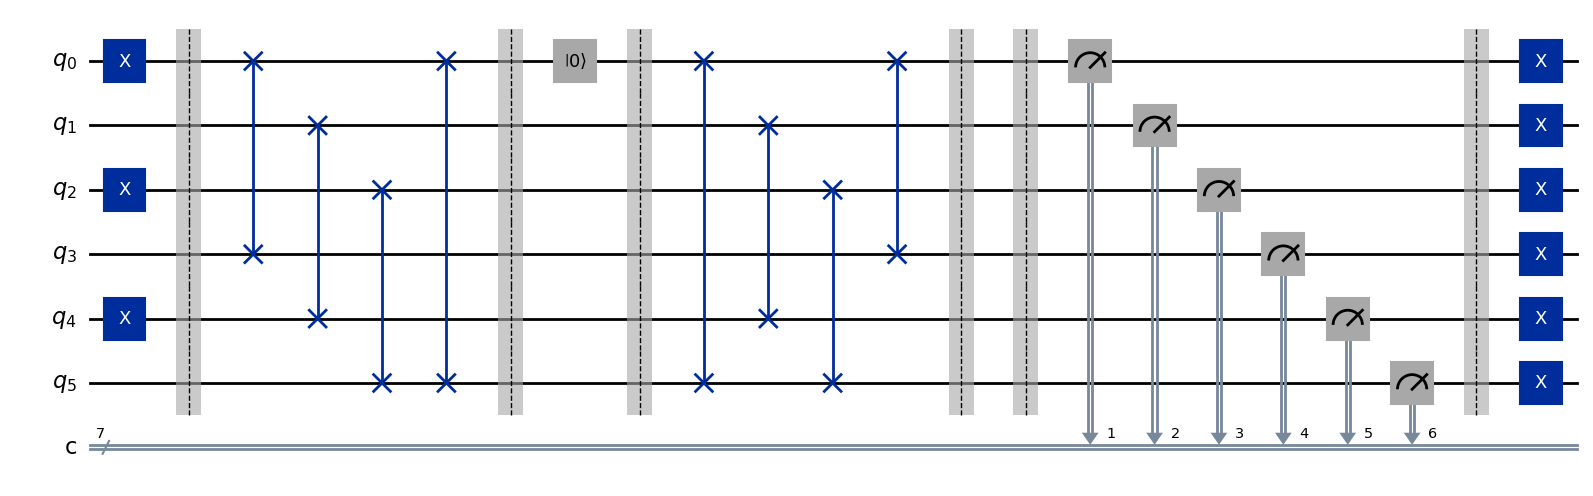

In [4]:

# Create explicit quantum and classical registers
N_q = 6 # Number of qubits in the code
N_m = 7 # Number of mid-measure classical bits


# 4 qubits, 4 classical bits
qc = QuantumCircuit(N_q, N_m)

# 1) Distinct initial pattern: 101010 on q[0..5]  (X on even indices)
qc.x([0, 2, 4])
qc.barrier()

# 2) Known permutation π via swaps
# Track mapping to know where original qubits land:
# Start    : idx -> orig = [0,1,2,3,4,5]
# swap(0,3): [3,1,2,0,4,5]
# swap(1,4): [3,4,2,0,1,5]
# swap(2,5): [3,4,5,0,1,2]
# swap(0,5): [2,4,5,0,1,3]   => index 0 now holds original qubit 2
qc.swap(0, 3)
qc.swap(1, 4)
qc.swap(2, 5)
qc.swap(0, 5)
qc.barrier()

# 3) Reset AFTER permutation: should reset the qubit currently at index 0 (i.e., original q2)
qc.reset(0)
qc.barrier()

# 4) Inverse permutation π^{-1} (undo in reverse order)
qc.swap(0, 5)
qc.swap(2, 5)
qc.swap(1, 4)
qc.swap(0, 3)
qc.barrier()


qc.barrier()

qc.measure(range(N_q), range(1, N_m))
qc.barrier()

qc.x(range(N_q))


qc.draw("mpl")


### Run

In [5]:

sim = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit)

#cycles = 2
initial_psi = np.zeros(2**N_q)
initial_psi[0] = 1.0  # set |00...0⟩
initial_layout = list(range(N_q))  # logical qubit 0→physical 0, 1→1, etc.
shots = 100

In [6]:
config = {
    "backend": {
        "hub": "ibm-q",
        "group": "open",
        "project": "main",
        "device_name": backend_name,
        "crn": CRN
    },
    "run": {
        "shots": shots,
        "qubits_layout": initial_layout,
        "psi0": initial_psi
    }
}

backend_config = config["backend"]
backend = setup_backend(Token=IBM_TOKEN, **backend_config)
run_config = config["run"]

qiskit_runtime_service._discover_account:WARNING:2025-11-04 18:18:45,851: Loading account with the given token. A saved account will not be used.


QiskitBackendNotFoundError: 'No backend matches the criteria. Learn more about available backends here https://quantum.cloud.ibm.com/docs/en/guides/qpu-information#view-your-resources'

In [ ]:
qubits_layout = run_config["qubits_layout"]
device_param = DeviceParameters(qubits_layout)
device_param.load_from_backend(backend)
device_param_lookup = device_param.__dict__()
bit_flip_bool = False

ValueError: The interaction gate of the backend is not implemented. Please choose another backend

In [ ]:




needs_controlflow = any(isinstance(op.operation, ControlFlowOp) for op in qc.data)

t_circ = transpile(
    qc,
    backend,
    initial_layout=qubits_layout,
    seed_transpiler=42,
    **({} if needs_controlflow else {"scheduling_method": "asap"})
)

res  = sim.run( 
    t_qiskit_circ=t_circ, 
    qubits_layout=qubits_layout, 
    psi0=np.array(run_config["psi0"]), 
    shots=run_config["shots"], 
    device_param=device_param_lookup,
    nqubit=N_q,
    bit_flip_bool=bit_flip_bool,
    )

probs = res["probs"]
results = res["results"]
num_clbits = res["num_clbits"]
mid_counts = res["mid_counts"]


print("Mid-circuit measurement results", results)
#print("Final measurement counts:", final_counts)
#print("Final measurement probabilities:", probs)
print("Number of classical bits in circuit:", num_clbits)
print("Mid-circuit measurement counts:", mid_counts)

---- Preprocessed data ----
Chunk 0: x[0] , delay[1] , x[2] , delay[3] , x[4] , delay[5] , delay[0] , delay[1]
Fancy 1: reset_qubits qubits=[2]
Chunk 2: delay[3] , delay[4] , delay[5]
Fancy 3: mid_measurement qubits=[0] clbits=[1]
Fancy 4: mid_measurement qubits=[1] clbits=[2]
Fancy 5: mid_measurement qubits=[2] clbits=[3]
Fancy 6: mid_measurement qubits=[3] clbits=[4]
Fancy 7: mid_measurement qubits=[4] clbits=[5]
Fancy 8: mid_measurement qubits=[5] clbits=[6]
Chunk 9: x[0] , x[1] , x[2] , x[3] , x[4] , x[5]
---------------------------
Layout mapping (phys→virt): [0, 2, 4, 1, 3, 5]
Reset (physical) targets: [2]
Layout mapping (phys→virt): [0, 2, 4, 1, 3, 5]
Reset (physical) targets: [2]
Layout mapping (phys→virt): [0, 2, 4, 1, 3, 5]
Reset (physical) targets: [2]
Layout mapping (phys→virt): [0, 2, 4, 1, 3, 5]
Reset (physical) targets: [2]
Layout mapping (phys→virt): [0, 2, 4, 1, 3, 5]
Reset (physical) targets: [2]
Layout mapping (phys→virt): [0, 2, 4, 1, 3, 5]
Reset (physical) targets:

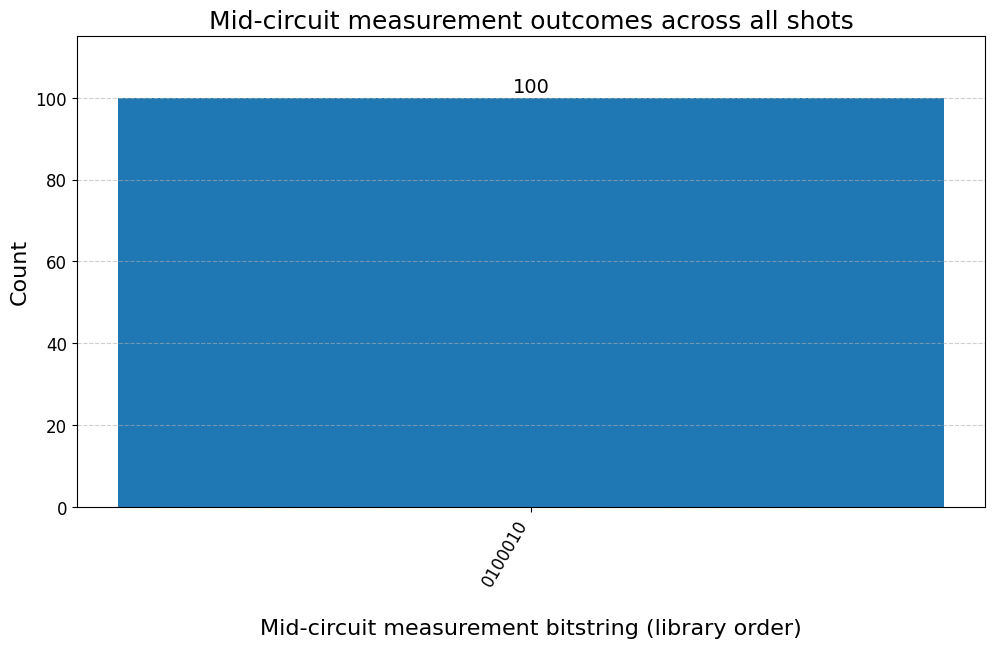

Mid-circuit measurement counts: {'0100010': 100}


In [ ]:

# --- Plot histogram ---
labels = sorted(mid_counts.keys())
values = [mid_counts[k] for k in labels]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color="#1f77b4")  # same default Aer blue

# Extend y-axis a bit to fit annotations
max_val = max(values)
plt.ylim(0, max_val * 1.15)

# Annotate bar tops
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.5, str(val),
             ha='center', va='bottom', fontsize=14, color="black")

plt.xlabel("\nMid-circuit measurement bitstring (library order)", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Mid-circuit measurement outcomes across all shots",fontsize=18)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.yticks(fontsize=12)
plt.xticks(rotation=60, ha="right", fontsize=12)   # tilt x-axis labels

plt.show()

# --- Optional printout ---
print("Mid-circuit measurement counts:", dict(mid_counts))

Modified Hist Plot of above 5% counts 

Filtered mid-circuit measurement counts

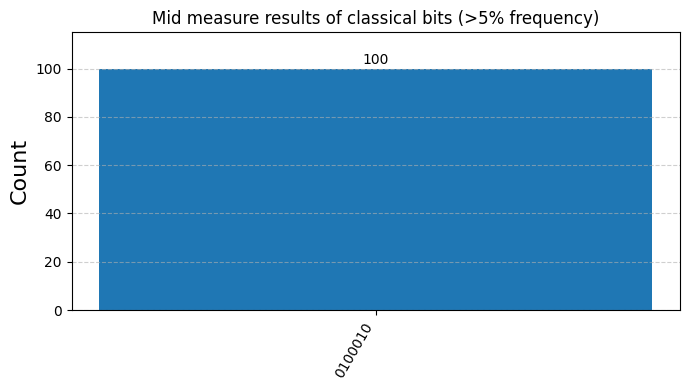

In [ ]:
threshold = 0.05 * shots  # 5% cutoff

# --- Filter ---
filtered_counts = {k: v for k, v in mid_counts.items() if v >= threshold}

# --- Sort by bitstring (optional) ---
filtered_labels = list(sorted(filtered_counts.keys()))
filtered_values = [filtered_counts[k] for k in filtered_labels]

# --- Plot ---
plt.figure(figsize=(7, 4))
bars = plt.bar(filtered_labels, filtered_values, color="#1f77b4")  # same default Aer blue

# Extend y-axis a bit to fit annotations
max_val = max(filtered_values)
plt.ylim(0, max_val * 1.15)

# Annotate bar tops
for bar, val in zip(bars, filtered_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.5, str(val),
             ha='center', va='bottom', fontsize=10, color="black")

# Match Aer-style axes
plt.ylabel("Count", fontsize=16)
plt.xlabel("")  # Aer histograms usually skip x-axis label
plt.title("Mid measure results of classical bits (>5% frequency)", fontsize=12)
plt.xticks(rotation=60, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Tight layout to match Aer formatting
plt.tight_layout()
plt.show()

Comparison with AER

In [ ]:
# Simulate with Aer
sim = AerSimulator()
t_qc = transpile(qc, sim)
result = sim.run(t_qc, shots=shots).result()
counts = result.get_counts()

Aer All clbits counts: {'0100010': 100}


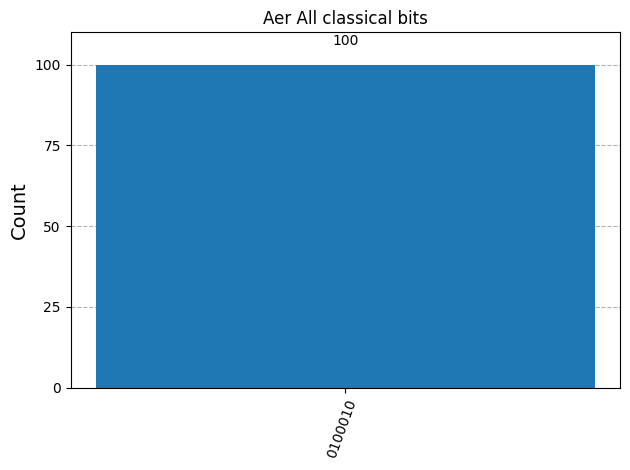

In [ ]:
print("Aer All clbits counts:", counts)
plot_histogram(counts, title="Aer All classical bits")